In [429]:
from detectdd import config
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow import keras


import pandas as pd
from detectdd.serializer import Serializer

from sklearn.model_selection import train_test_split



### Pipeline selection
The data array and the features in the csv need to match, so uncomment both of them out


In [430]:
# Switch between different csv files, haven't automated detection of this yet. The data array
# needs to match the feature columns in the csv, or those features will be ignored.

##### uncomment this set of features and 
data_arrays = ["heart_rate", "sbp", "dbp", "mbp"]

#vitals_filename='vitals_data_before_and_after.csv'
#vitals_filename = 'vitals_data_before_and_after_ABCD.csv')
vitals_filename = 'vitals_data_before_and_after_ABC.csv'

# this is the file produced by 02-ml-data-preprocessing-mulitplexed-bp
vitals_data_df = pd.read_csv(config.out_dir / vitals_filename)
vitals_no_ddi = pd.read_csv(config.out_dir / 'vitals_data_before_and_after_no_drug_interaction.csv')

# data_arrays = ["heart_rate", "sbp", "dbp", "mbp", "uric acid", "creatinine"]
# vitals_data_df = pd.read_csv('vitals_kidney_data.csv')

print(f"Duplicates found: {vitals_no_ddi[vitals_no_ddi['subject_id'].isin(vitals_data_df['subject_id'])]['subject_id'].nunique()}")
vitals_no_ddi = vitals_no_ddi[~vitals_no_ddi['subject_id'].isin(vitals_data_df['subject_id'])]
print(f"Remaining duplicates: {vitals_no_ddi[vitals_no_ddi['subject_id'].isin(vitals_data_df['subject_id'])]['subject_id'].nunique()}")
vitals_data_df.head(500)

Duplicates found: 937
Remaining duplicates: 0


,Unnamed: 0,stay_id,dose_b_time,subject_id,charttime,heart_rate,sbp,dbp,mbp
0,0,30004144,2126-04-07 11:46:00,10369174,2126-04-07 21:10:00,60.0,NaN,NaN,NaN
1,1,30004144,2126-04-07 11:46:00,10369174,2126-04-07 21:00:00,62.0,129.0,50.0,71.0
2,2,30004144,2126-04-07 11:46:00,10369174,2126-04-07 14:00:00,60.0,135.0,57.0,80.0
3,3,30004144,2126-04-07 11:46:00,10369174,2126-04-07 22:10:00,60.0,NaN,NaN,NaN
4,4,30004144,2126-04-07 11:46:00,10369174,2126-04-07 05:00:00,66.0,136.0,65.0,89.0
...,...,...,...,...,...,...,...,...,...
495,495,30084052,2160-09-27 08:00:00,15997269,2160-09-27 09:00:00,98.0,NaN,NaN,NaN
496,496,30084052,2160-09-27 08:00:00,15997269,2160-09-27 13:00:00,102.0,127.0,77.0,87.0
497,497,30084052,2160-09-27 08:00:00,15997269,2160-09-27 15:00:00,94.0,NaN,NaN,NaN
498,498,30084052,2160-09-27 08:00:00,15997269,2160-09-27 17:00:00,98.0,132.0,65.0,81.0


In [431]:
print(f"Unique subject ids {vitals_data_df['subject_id'].nunique()}")

Unique subject ids 1539


In [432]:
print(f"Drug interaction events {vitals_data_df[['subject_id', 'dose_b_time']].nunique()}")

Drug interaction events subject_id     1539
dose_b_time    6897
dtype: int64


In [433]:
def fix_csv_data_types(df):
    df["charttime"] = df["charttime"].astype("datetime64[s]")
    df["dose_b_time"] = df["dose_b_time"].astype("datetime64[s]")
    return df

vitals_data_df = fix_csv_data_types(vitals_data_df)
vitals_no_ddi = fix_csv_data_types(vitals_no_ddi)

vitals_data_df = vitals_data_df.sort_values(by=["stay_id", "dose_b_time", "charttime"])

try:
    serializer = Serializer()
    cohort_with_icd = serializer.read_cohort()  # need to run 01-cohort.ipynb to produce the cohort
except FileNotFoundError:
    raise Exception("Need to run [01-cohort.ipynb] at least once to create the cohort file in the /out directory")



print(vitals_data_df.describe())
print(vitals_no_ddi.describe())
vitals_data_df.head(500)



Loaded cohort from ..\out\cohort-full.out
          Unnamed: 0       stay_id          dose_b_time    subject_id  \
count  235790.000000  2.357900e+05               235790  2.357900e+05   
mean     9225.066801  3.503665e+07  2154-03-01 20:05:48  1.494233e+07   
min         0.000000  3.000414e+07  2110-03-02 18:20:00  1.000473e+07   
25%      2878.000000  3.250448e+07  2133-10-25 16:44:00  1.242906e+07   
50%      6527.000000  3.505892e+07  2154-01-19 13:42:00  1.491852e+07   
75%     12760.000000  3.761153e+07  2175-10-03 12:42:00  1.750911e+07   
max     39032.000000  3.999923e+07  2209-05-30 02:04:00  1.998326e+07   
std      8624.111674  2.920039e+06                  NaN  2.886914e+06   

                 charttime     heart_rate            sbp            dbp  \
count               235790  181098.000000  184156.000000  184113.000000   
mean   2154-03-01 20:06:03      90.212652     116.615189      61.411769   
min    2110-03-02 07:00:00       5.000000       8.000000       1.000000   


,Unnamed: 0,stay_id,dose_b_time,subject_id,charttime,heart_rate,sbp,dbp,mbp
56335,16,30004144,2126-04-04 18:43:00,10369174,2126-04-04 13:20:00,60.0,NaN,NaN,NaN
56343,24,30004144,2126-04-04 18:43:00,10369174,2126-04-04 13:21:00,NaN,132.0,53.0,78.0
56337,18,30004144,2126-04-04 18:43:00,10369174,2126-04-04 13:30:00,65.0,NaN,NaN,NaN
56322,3,30004144,2126-04-04 18:43:00,10369174,2126-04-04 13:31:00,NaN,139.0,60.0,87.0
56327,8,30004144,2126-04-04 18:43:00,10369174,2126-04-04 13:32:00,63.0,150.0,63.0,93.0
...,...,...,...,...,...,...,...,...,...
201205,7,30015010,2154-08-09 20:00:00,11365767,2154-08-10 06:00:00,101.0,116.0,84.0,92.0
201222,24,30015010,2154-08-09 20:00:00,11365767,2154-08-10 07:00:00,93.0,110.0,73.0,82.0
215743,22,30015010,2154-08-10 20:00:00,11365767,2154-08-10 09:00:00,85.0,NaN,NaN,NaN
215731,10,30015010,2154-08-10 20:00:00,11365767,2154-08-10 09:05:00,NaN,105.0,63.0,73.0


In [434]:
# join with icd code info to create has_icd

unique_subject_num_icd_codes = cohort_with_icd[["subject_id", "num_icd_codes"]].drop_duplicates(subset="subject_id")
print(unique_subject_num_icd_codes)

vitals_data_df = vitals_data_df.drop_duplicates()

vitals_data_df = pd.merge(left=vitals_data_df, right=unique_subject_num_icd_codes, how="inner", on='subject_id')
# generate the has_icd ground truth value
vitals_data_df["has_icd"] = ~vitals_data_df['num_icd_codes'].isna()

print(f"has_icd ratio {vitals_data_df['has_icd'].sum() / vitals_data_df['subject_id'].count()}")
print(f"Unique subject ids {vitals_data_df['subject_id'].nunique()}")

vitals_data_df.head(500)

       subject_id  num_icd_codes
4        10990398              1
11       11343484              2
14       11549427              2
47       12181540              1
87       14482820              1
...           ...            ...
49449    10828900              1
49491    16331109              1
49496    13370388              1
49508    18260575              2
49524    18896122              1

[1544 rows x 2 columns]
has_icd ratio 1.0
Unique subject ids 1539


,Unnamed: 0,stay_id,dose_b_time,subject_id,charttime,heart_rate,sbp,dbp,mbp,num_icd_codes,has_icd
0,16,30004144,2126-04-04 18:43:00,10369174,2126-04-04 13:20:00,60.0,NaN,NaN,NaN,2,True
1,24,30004144,2126-04-04 18:43:00,10369174,2126-04-04 13:21:00,NaN,132.0,53.0,78.0,2,True
2,18,30004144,2126-04-04 18:43:00,10369174,2126-04-04 13:30:00,65.0,NaN,NaN,NaN,2,True
3,3,30004144,2126-04-04 18:43:00,10369174,2126-04-04 13:31:00,NaN,139.0,60.0,87.0,2,True
4,8,30004144,2126-04-04 18:43:00,10369174,2126-04-04 13:32:00,63.0,150.0,63.0,93.0,2,True
...,...,...,...,...,...,...,...,...,...,...,...
495,7,30015010,2154-08-09 20:00:00,11365767,2154-08-10 06:00:00,101.0,116.0,84.0,92.0,1,True
496,24,30015010,2154-08-09 20:00:00,11365767,2154-08-10 07:00:00,93.0,110.0,73.0,82.0,1,True
497,22,30015010,2154-08-10 20:00:00,11365767,2154-08-10 09:00:00,85.0,NaN,NaN,NaN,1,True
498,10,30015010,2154-08-10 20:00:00,11365767,2154-08-10 09:05:00,NaN,105.0,63.0,73.0,1,True


In [435]:
# create the negative cohort
vitals_no_ddi['num_icd_codes'] = 0
vitals_no_ddi['has_icd'] = False
vitals_no_ddi = vitals_no_ddi[['stay_id', 'dose_b_time', 'subject_id', 'charttime', 'has_icd', 'num_icd_codes'] + data_arrays]
print(vitals_data_df.shape)
print(vitals_no_ddi.shape)
print(vitals_data_df.index)
print(vitals_no_ddi.index)

vitals_no_ddi

(235790, 11)
(910192, 10)
RangeIndex(start=0, stop=235790, step=1)
Index([      0,       1,       2,       3,       4,       5,       6,       7,
             8,       9,
       ...
       1060720, 1060721, 1060722, 1060723, 1060724, 1060725, 1060726, 1060727,
       1060728, 1060729],
      dtype='int64', length=910192)


,stay_id,dose_b_time,subject_id,charttime,has_icd,num_icd_codes,heart_rate,sbp,dbp,mbp
0,30000484,2136-01-15 22:02:00,18421337,2136-01-15 18:00:00,False,0,89.0,103.0,22.0,41.0
1,30000484,2136-01-15 22:02:00,18421337,2136-01-16 01:00:00,False,0,99.0,NaN,NaN,NaN
2,30000484,2136-01-15 22:02:00,18421337,2136-01-15 14:30:00,False,0,NaN,129.0,113.0,NaN
3,30000484,2136-01-15 22:02:00,18421337,2136-01-16 00:00:00,False,0,97.0,NaN,NaN,NaN
4,30000484,2136-01-15 22:02:00,18421337,2136-01-15 14:00:00,False,0,92.0,NaN,NaN,58.0
...,...,...,...,...,...,...,...,...,...,...
1060725,39323481,2121-03-10 08:34:00,11652327,2121-03-10 19:00:00,False,0,119.0,108.0,56.0,72.0
1060726,39323481,2121-03-10 08:34:00,11652327,2121-03-09 22:30:00,False,0,111.0,139.0,71.0,94.0
1060727,39323481,2121-03-10 08:34:00,11652327,2121-03-09 22:15:00,False,0,109.0,125.0,63.0,85.0
1060728,39323481,2121-03-10 08:34:00,11652327,2121-03-09 22:00:00,False,0,110.0,129.0,65.0,87.0


In [436]:
# make the target cohort and the negative cohort the same shape and join them together
stay_ids_with_icd = vitals_data_df["stay_id"].unique()
stay_ids_without_icd = vitals_no_ddi["stay_id"].unique()

print(len(stay_ids_with_icd))
print(len(stay_ids_without_icd))
min_balanced_len = min(len(stay_ids_with_icd), len(stay_ids_without_icd))
print(min_balanced_len)

balanced_with = vitals_data_df[vitals_data_df["stay_id"].isin(stay_ids_with_icd[:min_balanced_len])]
balanced_without = vitals_no_ddi[vitals_no_ddi["stay_id"].isin(stay_ids_without_icd[:min_balanced_len])]

df = pd.concat([balanced_with, balanced_without])
print(f"Size of target {len(balanced_with)}, size of negative {len(balanced_without)}, size of combined {len(df)}")

## convert chart_time to timestep relative to dose b time
df["timestep"] = df["charttime"] - df["dose_b_time"]
## and convert to float64 for tensor flow
df['timestep_float'] = df['timestep'].dt.total_seconds().astype('float64')

print(df.dtypes)

for data in data_arrays:
    df[data] = df[data].astype('float64')

print(df.dtypes)
print(df['has_icd'].describe())
df.head(50)

1672
10182
1672
Size of target 235790, size of negative 152664, size of combined 388454
Unnamed: 0               float64
stay_id                    int64
dose_b_time        datetime64[s]
subject_id                 int64
charttime          datetime64[s]
heart_rate               float64
sbp                      float64
dbp                      float64
mbp                      float64
num_icd_codes              Int64
has_icd                     bool
timestep          timedelta64[s]
timestep_float           float64
dtype: object
Unnamed: 0               float64
stay_id                    int64
dose_b_time        datetime64[s]
subject_id                 int64
charttime          datetime64[s]
heart_rate               float64
sbp                      float64
dbp                      float64
mbp                      float64
num_icd_codes              Int64
has_icd                     bool
timestep          timedelta64[s]
timestep_float           float64
dtype: object
count     388454
unique   

,Unnamed: 0,stay_id,dose_b_time,subject_id,charttime,heart_rate,sbp,dbp,mbp,num_icd_codes,has_icd,timestep,timestep_float
0,16.0,30004144,2126-04-04 18:43:00,10369174,2126-04-04 13:20:00,60.0,NaN,NaN,NaN,2,True,-1 days +18:37:00,-19380.0
1,24.0,30004144,2126-04-04 18:43:00,10369174,2126-04-04 13:21:00,NaN,132.0,53.0,78.0,2,True,-1 days +18:38:00,-19320.0
2,18.0,30004144,2126-04-04 18:43:00,10369174,2126-04-04 13:30:00,65.0,NaN,NaN,NaN,2,True,-1 days +18:47:00,-18780.0
3,3.0,30004144,2126-04-04 18:43:00,10369174,2126-04-04 13:31:00,NaN,139.0,60.0,87.0,2,True,-1 days +18:48:00,-18720.0
4,8.0,30004144,2126-04-04 18:43:00,10369174,2126-04-04 13:32:00,63.0,150.0,63.0,93.0,2,True,-1 days +18:49:00,-18660.0
5,7.0,30004144,2126-04-04 18:43:00,10369174,2126-04-04 13:45:00,63.0,140.0,59.0,86.0,2,True,-1 days +19:02:00,-17880.0
6,10.0,30004144,2126-04-04 18:43:00,10369174,2126-04-04 14:00:00,94.0,135.0,58.0,82.0,2,True,-1 days +19:17:00,-16980.0
7,19.0,30004144,2126-04-04 18:43:00,10369174,2126-04-04 14:15:00,67.0,156.0,66.0,100.0,2,True,-1 days +19:32:00,-16080.0
8,0.0,30004144,2126-04-04 18:43:00,10369174,2126-04-04 14:30:00,NaN,141.0,67.0,95.0,2,True,-1 days +19:47:00,-15180.0
9,23.0,30004144,2126-04-04 18:43:00,10369174,2126-04-04 14:31:00,70.0,NaN,NaN,NaN,2,True,-1 days +19:48:00,-15120.0


In [437]:
df = df[["stay_id", "timestep", "timestep_float", "dose_b_time", "charttime",
         "has_icd"] + data_arrays].sort_values(["stay_id", "dose_b_time", "timestep"])
df.head(50)

,stay_id,timestep,timestep_float,dose_b_time,charttime,has_icd,heart_rate,sbp,dbp,mbp
5,30000484,-1 days +12:58:00,-39720.0,2136-01-15 22:02:00,2136-01-15 11:00:00,False,94.0,108.0,43.0,60.0
6,30000484,-1 days +13:58:00,-36120.0,2136-01-15 22:02:00,2136-01-15 12:00:00,False,93.0,114.0,44.0,60.0
7,30000484,-1 days +14:58:00,-32520.0,2136-01-15 22:02:00,2136-01-15 13:00:00,False,95.0,113.0,66.0,72.0
4,30000484,-1 days +15:58:00,-28920.0,2136-01-15 22:02:00,2136-01-15 14:00:00,False,92.0,NaN,NaN,58.0
2,30000484,-1 days +16:28:00,-27120.0,2136-01-15 22:02:00,2136-01-15 14:30:00,False,NaN,129.0,113.0,NaN
24,30000484,-1 days +16:58:00,-25320.0,2136-01-15 22:02:00,2136-01-15 15:00:00,False,94.0,133.0,61.0,79.0
19,30000484,-1 days +17:58:00,-21720.0,2136-01-15 22:02:00,2136-01-15 16:00:00,False,93.0,117.0,74.0,82.0
17,30000484,-1 days +18:58:00,-18120.0,2136-01-15 22:02:00,2136-01-15 17:00:00,False,87.0,119.0,65.0,78.0
0,30000484,-1 days +19:58:00,-14520.0,2136-01-15 22:02:00,2136-01-15 18:00:00,False,89.0,103.0,22.0,41.0
20,30000484,-1 days +20:58:00,-10920.0,2136-01-15 22:02:00,2136-01-15 19:00:00,False,88.0,118.0,74.0,82.0


# Interpolate
The data has missing values, use pandas built in interpolation to fill those based on the timestamp

In [461]:
import pandas as pd

print(df.dtypes)
# df = df.reset_index()
df.set_index('charttime', inplace=True)

def interpolate_group(group):
    if group.name in data_arrays:
        # Perform interpolation for the group
        group = group.interpolate(method='time')

    return group

# Apply the interpolation function to each group
df = df.apply(interpolate_group).reset_index()

grouped_df = df[["stay_id", "dose_b_time", "timestep_float","has_icd"]+data_arrays]
print(df.dtypes)
print(grouped_df.columns)
print(grouped_df.shape)
grouped_df.head(50)

charttime          datetime64[s]
stay_id                    int64
timestep          timedelta64[s]
timestep_float           float64
dose_b_time        datetime64[s]
has_icd                     bool
heart_rate               float64
sbp                      float64
dbp                      float64
mbp                      float64
dtype: object
charttime          datetime64[s]
stay_id                    int64
timestep          timedelta64[s]
timestep_float           float64
dose_b_time        datetime64[s]
has_icd                     bool
heart_rate               float64
sbp                      float64
dbp                      float64
mbp                      float64
dtype: object


NameError: name 'groupd_df' is not defined

# Remove outliers

In [439]:
# reduce the size of the data arrays to the p999 to get rid of the extreme outliers
length = pd.DataFrame()
length["val"] = [len(array) for array in grouped_df.groupby(["stay_id", "dose_b_time"])["mbp"]]
print(length.describe(percentiles=[0.01, 0.025, 0.25, 0.5, 0.75, 0.975, 0.99, 0.999]))
print(grouped_df.dtypes)
max_size = 90  # p999

data_array_with_time = data_arrays.copy()
data_array_with_time.append("timestep_float")
print(data_array_with_time)
print(data_arrays)

grouped_df = grouped_df.groupby(["stay_id", "dose_b_time"]).head(max_size)

max_sequence_length = max(len(array) for array in grouped_df.groupby(["stay_id", "dose_b_time"])["sbp"])
print(max_sequence_length)

grouped_df

           val
count  11608.0
mean       2.0
std        0.0
min        2.0
1%         2.0
2.5%       2.0
25%        2.0
50%        2.0
75%        2.0
97.5%      2.0
99%        2.0
99.9%      2.0
max        2.0
stay_id                   int64
dose_b_time       datetime64[s]
timestep_float          float64
has_icd                    bool
heart_rate              float64
sbp                     float64
dbp                     float64
mbp                     float64
dtype: object
['heart_rate', 'sbp', 'dbp', 'mbp', 'timestep_float']
['heart_rate', 'sbp', 'dbp', 'mbp']
2


,stay_id,dose_b_time,timestep_float,has_icd,heart_rate,sbp,dbp,mbp
0,30000484,2136-01-15 22:02:00,-39720.0,False,94.0,108.000000,43.000000,60.0
1,30000484,2136-01-15 22:02:00,-36120.0,False,93.0,114.000000,44.000000,60.0
2,30000484,2136-01-15 22:02:00,-32520.0,False,95.0,113.000000,66.000000,72.0
3,30000484,2136-01-15 22:02:00,-28920.0,False,92.0,123.666667,97.333333,58.0
4,30000484,2136-01-15 22:02:00,-27120.0,False,93.0,129.000000,113.000000,68.5
...,...,...,...,...,...,...,...,...
388449,39999230,2147-09-08 00:23:00,27420.0,True,69.0,117.000000,58.000000,79.0
388450,39999230,2147-09-08 00:23:00,31020.0,True,79.0,123.000000,65.000000,87.0
388451,39999230,2147-09-08 00:23:00,34620.0,True,66.0,111.000000,59.000000,78.0
388452,39999230,2147-09-08 00:23:00,38220.0,True,63.0,110.000000,57.000000,76.0


# Unify timesteps
The time measurement data varies per dosage, this step aligns all the time steps to 10 minute intervals, and interpolates between our 
existing time measures to produce 12 hours of 10 minute timestaps 

In [440]:
# first fill blank values through interpellation
from scipy.interpolate import interp1d

HOURS = 12
MIN_INCREMENTS = 10

def interpolate_row(row):
    vals = pd.DataFrame()
    time_steps = np.array(row["timestep_float"])
    common_time_interval = range(HOURS * -60, HOURS * 60, MIN_INCREMENTS)

    for data_array in data_arrays:
        interp_func = interp1d(time_steps, row[data_array], kind='next', fill_value='extrapolate')
        vals["intr-" + data_array] = interp_func(common_time_interval)

    vals["common_timestep"] = common_time_interval
    return vals


# Apply the function to the specific subset of rows
interpolated_df = grouped_df.groupby(['stay_id', 'has_icd', 'dose_b_time']).apply(interpolate_row)
print(interpolated_df)

interpolated_df.head(500)

                                          intr-heart_rate  intr-sbp  intr-dbp  \
stay_id  has_icd dose_b_time                                                    
30000484 False   2136-01-15 22:02:00 0              105.0     147.0      79.0   
                                     1              105.0     147.0      79.0   
                                     2              105.0     147.0      79.0   
                                     3              105.0     147.0      79.0   
                                     4              105.0     147.0      79.0   
...                                                   ...       ...       ...   
39999230 True    2147-09-08 00:23:00 139             66.0     110.0      57.0   
                                     140             66.0     110.0      57.0   
                                     141             66.0     110.0      57.0   
                                     142             66.0     110.0      57.0   
                            

intr-heart_rate  intr-sbp  intr-dbp  \
stay_id  has_icd dose_b_time                                                   
30000484 False   2136-01-15 22:02:00 0             105.0     147.0      79.0   
                                     1             105.0     147.0      79.0   
                                     2             105.0     147.0      79.0   
                                     3             105.0     147.0      79.0   
                                     4             105.0     147.0      79.0   
...                                                  ...       ...       ...   
30004144 True    2126-04-04 18:43:00 63             81.0     115.0      56.0   
                                     64             81.0     115.0      56.0   
                                     65             81.0     115.0      56.0   
                                     66             81.0     115.0      56.0   
                                     67             81.0     115.0      56.0   

                                         intr-mbp  common_timestep  
stay_id  has_icd dose_b_time                                        
30000484 False   2136-01-15 22:02:00 0       96.0             -720  
                                     1       96.0             -710  
                                     2       96.0             -700  
                                     3       96.0             -690  
                                     4       96.0             -680  
...                                           ...              ...  
30004144 True    2126-04-04 18:43:00 63      74.0              -90  
                                     64      74.0              -80  
                                     65      74.0              -70  
                                     66      74.0              -60  
                                     67      74.0              -50  

[500 rows x 5 columns]

# Normalise and scale data

In [441]:
from sklearn.preprocessing import RobustScaler
# 
features = []
for data in data_arrays:
    features.append('intr-'+data)

print(features)
# Initialize the RobustScaler
scaler = RobustScaler()

# Fit and transform the column

for feature in features:
    interpolated_df[feature] = scaler.fit_transform(interpolated_df[[feature]])

print(interpolated_df.head(50))


['intr-heart_rate', 'intr-sbp', 'intr-dbp', 'intr-mbp']
                                         intr-heart_rate  intr-sbp  intr-dbp  \
stay_id  has_icd dose_b_time                                                   
30000484 False   2136-01-15 22:02:00 0              0.68  1.103448  1.132075   
                                     1              0.68  1.103448  1.132075   
                                     2              0.68  1.103448  1.132075   
                                     3              0.68  1.103448  1.132075   
                                     4              0.68  1.103448  1.132075   
                                     5              0.68  1.103448  1.132075   
                                     6              0.68  1.103448  1.132075   
                                     7              0.68  1.103448  1.132075   
                                     8              0.68  1.103448  1.132075   
                                     9              0.68  1.1034

In [442]:
interpolated_df = interpolated_df.reset_index()
print(interpolated_df.groupby(['stay_id'])['has_icd'].agg(lambda x : all(x)).sum())
has_icd = interpolated_df.groupby(['stay_id'])['has_icd'].agg(lambda x : all(x)).sum()
print(len(interpolated_df['stay_id'].unique()))
print (has_icd / len(interpolated_df['stay_id'].unique()))
interpolated_df.shape

1672
3344
0.5


(1671552, 9)

In [443]:
interpolated_df.head(100)

,stay_id,has_icd,dose_b_time,level_3,intr-heart_rate,intr-sbp,intr-dbp,intr-mbp,common_timestep
0,30000484,False,2136-01-15 22:02:00,0,0.68,1.103448,1.132075,1.075391,-720
1,30000484,False,2136-01-15 22:02:00,1,0.68,1.103448,1.132075,1.075391,-710
2,30000484,False,2136-01-15 22:02:00,2,0.68,1.103448,1.132075,1.075391,-700
3,30000484,False,2136-01-15 22:02:00,3,0.68,1.103448,1.132075,1.075391,-690
4,30000484,False,2136-01-15 22:02:00,4,0.68,1.103448,1.132075,1.075391,-680
...,...,...,...,...,...,...,...,...,...
95,30000484,False,2136-01-15 22:02:00,95,0.32,0.379310,0.622642,0.285917,230
96,30000484,False,2136-01-15 22:02:00,96,0.32,0.379310,0.622642,0.285917,240
97,30000484,False,2136-01-15 22:02:00,97,0.32,0.379310,0.622642,0.285917,250
98,30000484,False,2136-01-15 22:02:00,98,0.32,0.379310,0.622642,0.285917,260


# Reshape the arrays to be a uniform 3D tensor
Pads with extra zeros for dosages that do not have max_dosage measures

In [444]:
from numpy import shape
from keras_preprocessing.sequence import pad_sequences

target = 'has_icd'

# Extract features and timestep data

# interpolated_df = interpolated_df.reset_index()
timesteps_with_icd = interpolated_df[interpolated_df["has_icd"]].groupby(["stay_id", "dose_b_time"])['common_timestep'].count()
timesteps_without_icd = interpolated_df[~interpolated_df["has_icd"]].groupby(["stay_id", "dose_b_time"])['common_timestep'].count()
print(timesteps_with_icd.describe())
print(timesteps_without_icd.describe())

timesteps = interpolated_df.groupby(["stay_id", "dose_b_time"])['common_timestep'].count()

# Determine the maximum sequence length
max_sequence_length = max(timesteps)
print(f"Max sequence length {max_sequence_length}")

max_dosages = min(df.groupby("stay_id")["dose_b_time"].nunique().max(), 10)
print(f"Max dosages {max_dosages}")

X_sequences = []
y_sequences = []
zeros = np.zeros((max_sequence_length, len(features))) # an array of timestep zeros * features for padding the tensor

# Initialize an empty list to store arrays
result = []

# Collect any invalid stays
invalid_stays = []

# Organize data by stay_id
stay_ids = interpolated_df['stay_id'].unique()
for stay_id in stay_ids:
    # Filter the DataFrame for the current key1
    df_stays = interpolated_df[interpolated_df["stay_id"] == stay_id]

    # Create a list to store arrays for the current key1
    stays_array = []

    unique_doses = df_stays['dose_b_time'].unique()
    # Iterate over unique values of key2 within the current key1
    for idx, dose_b_time in enumerate(unique_doses):
        if idx >= max_dosages:
            break
  
            
        # Filter the DataFrame for the current key2
        df_dose = df_stays[df_stays["dose_b_time"] == dose_b_time]
    
        # Extract the feature values
        val_columns = df_dose[features].values
        
        # Append the extracted values as an array to the list if they are all valid
        if ~np.any(np.isnan(val_columns)):
            stays_array.append(val_columns)
        else:
            invalid_stays.append(stay_id) ## collect invalid stay ids if NaNs are found
            print(f"Found array values with NaN {stay_id} ")
        
    if len(stays_array) > 0:
        # Convert the list of arrays to a NumPy array for the current key1
        stays_array = np.array(stays_array)
        if ~(np.all(df_stays[target]) | ~np.any(df_stays[target])):
            print(f"Found inconsistent icd code {df_stays[target]}")
            
        y_sequences.append(df_stays[target].unique()[0])
        # normalise the varying number of measure events, down to mean and variance of each time step
        stay_summary_array = list()
        stay_summary_array.append(np.mean(stays_array, axis=0))
        stay_summary_array.append(np.var(stays_array, axis=0))
        stay_summary_array.append(np.min(stays_array, axis=0))
        stay_summary_array.append(np.max(stays_array, axis=0))
        result.append(stay_summary_array)
    

# Convert the result list to a NumPy array
X_sequences = np.array(result)
y_sequences = np.array(y_sequences).astype(int)

print(f"Original shape {shape(X_sequences)}")
print(len(shape(X_sequences)))
# flatten from 4D tensor to 3D tensor, this effectively creates features out of each summary stat for each
# feature. We have 4 summary stats (min, max, mean and variance) and 4 features (bp, mbp, sbp, dbp)
if len(shape(X_sequences)) > 3:
    original_shape = X_sequences.shape
    X_sequences = X_sequences.reshape(original_shape[0], original_shape[2], original_shape[1] * original_shape[3])
    
    print(f"Reshaped X {shape(X_sequences)}")
    print(f"Shape of Y {shape(y_sequences)}")

print(f"Found {len(invalid_stays)} - {invalid_stays}")

count    6899.0
mean      144.0
std         0.0
min       144.0
25%       144.0
50%       144.0
75%       144.0
max       144.0
Name: common_timestep, dtype: float64
count    4709.0
mean      144.0
std         0.0
min       144.0
25%       144.0
50%       144.0
75%       144.0
max       144.0
Name: common_timestep, dtype: float64
Max sequence length 144
Max dosages 10
Found array values with NaN 30007565 
Found array values with NaN 30062341 
Found array values with NaN 30215114 
Found array values with NaN 30282193 
Found array values with NaN 30459604 
Found array values with NaN 30709267 
Found array values with NaN 30865290 
Found array values with NaN 31035417 
Found array values with NaN 31044655 
Found array values with NaN 31169797 
Found array values with NaN 31277766 
Found array values with NaN 31339001 
Found array values with NaN 31540850 
Found array values with NaN 31651307 
Found array values with NaN 31706336 
Found array values with NaN 31848963 
Found array values wi

In [445]:
# Restrict the size of the data so speed things up, delete this for a full production run
X = X_sequences #[:1500]
y = y_sequences #[:1500]

# Generate random indices for sampling, this is to reduce the sample size to speed up machine learning
## XXXXXXXXXXXXXXX This sample size reduces the cohort XXXXX
# sample_size = 2000
# random_indices = np.random.choice(len(X), size=sample_size, replace=False)
# 
# # Use the random indices to select elements from both arrays
# X = X_sequences[random_indices]
# y = y_sequences[random_indices]

print(f"Cohort reduced from {len(X_sequences)} to {len(X)} by sampling")
print(shape(X))
print(shape(y))
print(f"Ratio of positive to negative, should be 0.5 {np.sum(y) / len(y)}")


Cohort reduced from 3337 to 3337 by sampling
(3337, 144, 16)
(3337,)
Ratio of positive to negative, should be 0.5 0.49925082409349714


# Split into test and train sets

In [446]:
print(len(X))
print(len(y))

#Adjust the size of the testing set: we'll use 10% of the entire data. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=2)

#Check the number of columns (features):
print(len(X_train))
print(shape(X_train))
print(shape(X_test))
print(shape(y_train))
print(shape(y_test))


3337
3337
3003
(3003, 144, 16)
(334, 144, 16)
(3003,)
(334,)


# The RNN Model selection
Compare and constrast between two RNN implementations, GRU and LSTM models

Hyperparameters of dropout, recurrrent_activation and number of units were compared

### Hyperparameter training for GRU

In [447]:

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'units': [16, 32, 64],
    'dropout': [0.2, 0.4, 0.5],
    'recurrent_activation' : ['hard_sigmoid'],
}

def create_gru_model(units, dropout, recurrent_activation):
    model = keras.Sequential()

    model.add(keras.layers.Masking(mask_value=0))
    # model.add(LSTM(32, dropout=0.2, return_sequences=True))
    model.add(GRU(units=units, dropout=dropout, reset_after=True, activation='tanh', recurrent_activation=recurrent_activation))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

kc = KerasClassifier(build_fn=create_gru_model, batch_size=25, epochs=5)

## XXXXXXXXXXXXXXX This sample size reduces the cohort XXXXX
sample_size = 1000
random_indices = np.random.choice(len(X), size=sample_size, replace=False)

# Use the random indices to select elements from both arrays
X_cv = X_sequences[random_indices]
y_cv = y_sequences[random_indices]

#Call the GridSearchCV function to analyse each possible combination of parameters
#split training data into 5 folds, train with 4 validate with the 5th, change the training 4
CV_gru = GridSearchCV(estimator = kc, param_grid = param_grid, cv= 3, verbose=True, refit=False, scoring='accuracy')
CV_gru.fit(X_cv, y_cv)


Fitting 3 folds for each of 9 candidates, totalling 27 fits


C:\Users\stlan\AppData\Local\Temp\ipykernel_17852\2315931116.py:20: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  kc = KerasClassifier(build_fn=create_gru_model, batch_size=25, epochs=5)


Epoch 1/5
27/27 [==============================] - 6s 101ms/step - loss: 0.6908 - accuracy: 0.5616
Epoch 2/5
27/27 [==============================] - 3s 102ms/step - loss: 0.6796 - accuracy: 0.5826
Epoch 3/5
27/27 [==============================] - 3s 101ms/step - loss: 0.6833 - accuracy: 0.5856
Epoch 4/5
27/27 [==============================] - 3s 101ms/step - loss: 0.6821 - accuracy: 0.5691
Epoch 5/5
11/11 [==============================] - 1s 20ms/step
Epoch 1/5
27/27 [==============================] - 5s 98ms/step - loss: 0.6929 - accuracy: 0.5262
Epoch 2/5
27/27 [==============================] - 3s 107ms/step - loss: 0.6722 - accuracy: 0.5907
Epoch 3/5
27/27 [==============================] - 3s 100ms/step - loss: 0.6663 - accuracy: 0.6087
Epoch 4/5
27/27 [==============================] - 3s 100ms/step - loss: 0.6755 - accuracy: 0.6027
Epoch 5/5
11/11 [==============================] - 1s 21ms/step
Epoch 1/5
27/27 [==============================] - 5s 97ms/step - loss: 0.7009 - 

GridSearchCV(cv=3,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x0000016190F74C10>,
             param_grid={'dropout': [0.2, 0.4, 0.5],
                         'recurrent_activation': ['hard_sigmoid'],
                         'units': [16, 32, 64]},
             refit=False, scoring='accuracy', verbose=True)

In [448]:
CV_gru.best_params_

{'dropout': 0.5, 'recurrent_activation': 'hard_sigmoid', 'units': 32}

In [449]:
from keras.layers import LSTM, Dense, GRU
from keras.callbacks import EarlyStopping

model = create_gru_model(units=CV_gru.best_params_['units'], 
                         dropout=CV_gru.best_params_['dropout'],
                         recurrent_activation=CV_gru.best_params_['recurrent_activation'])

print(f"Compiled with {CV_gru.best_params_}")
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Compiled with {'dropout': 0.5, 'recurrent_activation': 'hard_sigmoid', 'units': 32}


In [450]:
def fit_model(model):
    EPOCHS = 100         # increase to at least 50
    BATCH_SIZE = 100     # increase to at least 100
    
    early_stopping = EarlyStopping(monitor='accuracy', patience=15, mode='auto', verbose = 1, min_delta=0.002, restore_best_weights=False)
    
    # callbacks=[early_stopping],
    print(f"Running with EPOCHS{EPOCHS} and BATCH_SIZE{BATCH_SIZE} and shape {shape(X_train)}")
    
    return model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping],
                           verbose=1)  #set verbose = 1 to see the fitting process

gru_classifier = fit_model(model)

Running with EPOCHS100 and BATCH_SIZE100 and shape (3003, 144, 16)
Epoch 1/100
31/31 [==============================] - 9s 169ms/step - loss: 0.6959 - accuracy: 0.5471
Epoch 2/100
31/31 [==============================] - 5s 164ms/step - loss: 0.6783 - accuracy: 0.5844
Epoch 3/100
31/31 [==============================] - 5s 166ms/step - loss: 0.6724 - accuracy: 0.5891
Epoch 4/100
31/31 [==============================] - 5s 163ms/step - loss: 0.6711 - accuracy: 0.5874
Epoch 5/100
31/31 [==============================] - 5s 166ms/step - loss: 0.6721 - accuracy: 0.5844
Epoch 6/100
31/31 [==============================] - 5s 169ms/step - loss: 0.6687 - accuracy: 0.5994
Epoch 7/100
31/31 [==============================] - 5s 160ms/step - loss: 0.6710 - accuracy: 0.5927
Epoch 8/100
31/31 [==============================] - 5s 159ms/step - loss: 0.6707 - accuracy: 0.5897
Epoch 9/100
31/31 [==============================] - 5s 159ms/step - loss: 0.6687 - accuracy: 0.5897
Epoch 10/100
31/31 [====

# Evaluate the training 
Plots of accuracy and loss for the training history

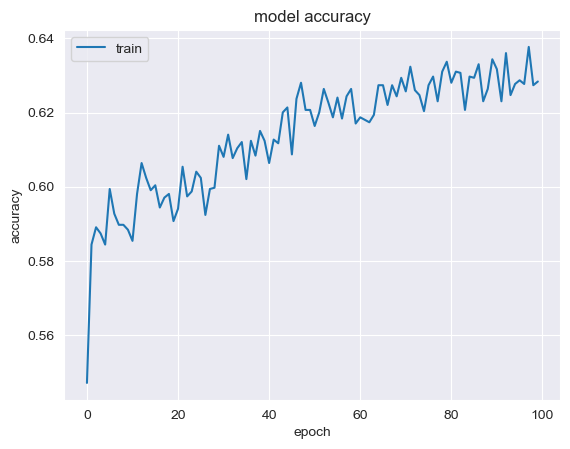

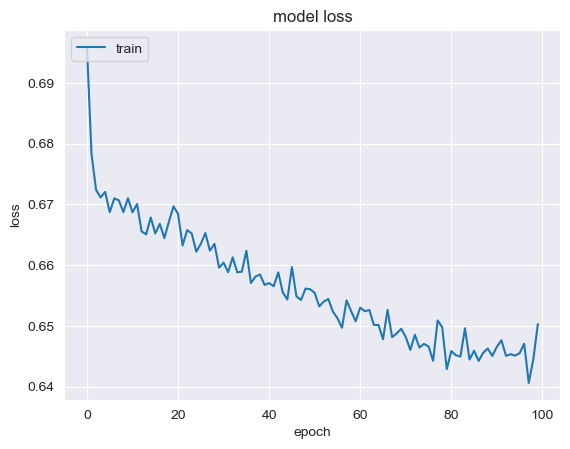

In [451]:
def plot_model(classifier):
    # Plot Accuracy over the epochs
    plt.plot(classifier.history['accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.title('model accuracy')
    plt.legend(['train'], loc='upper left')
    plt.show()
    
    # Plot Loss over the epochs
    plt.plot(classifier.history['loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title('model loss')
    plt.legend(['train'], loc='upper left')
    plt.show()

plot_model(gru_classifier)

In [452]:
# evaluate the keras model
def evaluate_model(model):
    loss, accuracy = model.evaluate(X_train[:1000], y_train[:1000])
    print('Accuracy: %.2f' % (accuracy*100))
    print(round(loss,3),round(accuracy,3))

evaluate_model(model)

32/32 [==============================] - 2s 25ms/step - loss: 0.6416 - accuracy: 0.6380
Accuracy: 63.80
0.642 0.638


# Test accuracy
Run model predictions on the test data set and report metrics scores, including MCC and F1 

In [453]:
from sklearn import metrics

def test_accuracy(model):
    # #Predict the testing set
    predictions = (model.predict(X_test) > 0.5).astype(int)
    
    #Accuracy classification score
    acc = float(round(metrics.accuracy_score(y_test, predictions),3))
    
    #Compute the balanced accuracy.
    bacc = float(round(metrics.balanced_accuracy_score(y_test, predictions),3))
    
    #Compute the Matthews correlation coefficient (MCC)
    mcc = float(round(metrics.matthews_corrcoef(y_test, predictions),3))
    
    #Compute the F1 score, also known as balanced F-score or F-measure.
    f1 = float(round(metrics.f1_score(y_test, predictions),3))
    
    #Show results as a DataFrame:
    results = {'Accuracy' : [acc], 'Balanced Accuracy' : [bacc], 'MCC' : [mcc], 'F1-Score' : [f1]}
    df_results = pd.DataFrame.from_dict(data = results, orient='columns')
    print(df_results)

print("************ GRU Evaluation ************")
print(f"Compiled with {CV_gru.best_params_}")
print(vitals_filename)
print(shape(X_sequences))
test_accuracy(model)

************ GRU Evaluation ************
Compiled with {'dropout': 0.5, 'recurrent_activation': 'hard_sigmoid', 'units': 32}
vitals_data_before_and_after_ABC.csv
11/11 [==============================] - 1s 22ms/step
   Accuracy  Balanced Accuracy    MCC  F1-Score
0     0.506              0.508  0.017     0.489


### Comparison with LSTM

In [463]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'units': [24, 32, 48],
    'dropout': [0.15, 0.2, 0.3],
    'recurrent_activation' : ['sigmoid', 'hard_sigmoid'],
}

def create_ltsm_model(units, dropout, recurrent_activation):
    model = keras.Sequential()

    model.add(keras.layers.Masking(mask_value=0))
    # model.add(LSTM(32, dropout=0.2, return_sequences=True))
    model.add(LSTM(units=units, dropout=dropout, activation='tanh', recurrent_activation=recurrent_activation))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

kc = KerasClassifier(build_fn=create_ltsm_model, batch_size=25, epochs=5)

## XXXXXXXXXXXXXXX This sample size reduces the cohort XXXXX
sample_size = 1000
random_indices = np.random.choice(len(X), size=sample_size, replace=False)

# Use the random indices to select elements from both arrays
X_cv = X_sequences[random_indices]
y_cv = y_sequences[random_indices]

#Call the GridSearchCV function to analyse each possible combination of parameters
#split training data into 5 folds, train with 4 validate with the 5th, change the training 4
CV_ltsm = GridSearchCV(estimator = kc, param_grid = param_grid, cv= 3, verbose=True, refit=False, scoring='accuracy')
CV_ltsm.fit(X_cv, y_cv)


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Epoch 1/5


C:\Users\stlan\AppData\Local\Temp\ipykernel_17852\3364380845.py:20: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  kc = KerasClassifier(build_fn=create_ltsm_model, batch_size=25, epochs=5)


27/27 [==============================] - 9s 61ms/step - loss: 0.6892 - accuracy: 0.5450
Epoch 2/5
27/27 [==============================] - 2s 61ms/step - loss: 0.6787 - accuracy: 0.5766
Epoch 3/5
27/27 [==============================] - 2s 62ms/step - loss: 0.6670 - accuracy: 0.5961
Epoch 4/5
27/27 [==============================] - 2s 61ms/step - loss: 0.6667 - accuracy: 0.6006
Epoch 5/5
11/11 [==============================] - 2s 16ms/step
Epoch 1/5
27/27 [==============================] - 8s 68ms/step - loss: 0.6859 - accuracy: 0.5547
Epoch 2/5
27/27 [==============================] - 2s 70ms/step - loss: 0.6760 - accuracy: 0.5742
Epoch 3/5
27/27 [==============================] - 2s 69ms/step - loss: 0.6759 - accuracy: 0.5757
Epoch 4/5
27/27 [==============================] - 2s 75ms/step - loss: 0.6721 - accuracy: 0.5832
Epoch 5/5
11/11 [==============================] - 2s 15ms/step
Epoch 1/5
27/27 [==============================] - 8s 68ms/step - loss: 0.6867 - accuracy: 0.5412


GridSearchCV(cv=3,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x0000016065E1CC70>,
             param_grid={'dropout': [0.15, 0.2, 0.3],
                         'recurrent_activation': ['sigmoid', 'hard_sigmoid'],
                         'units': [24, 32, 48]},
             refit=False, scoring='accuracy', verbose=True)

In [464]:
CV_ltsm.best_params_

{'dropout': 0.3, 'recurrent_activation': 'hard_sigmoid', 'units': 48}

In [465]:
from keras.layers import LSTM, Dense, GRU
from keras.callbacks import EarlyStopping

ltsm_model = create_ltsm_model(units=CV_ltsm.best_params_['units'],
                          dropout=CV_ltsm.best_params_['dropout'],
                          recurrent_activation=CV_ltsm.best_params_['recurrent_activation'])

print(f"Compiled with {CV_ltsm.best_params_}")
ltsm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Compiled with {'dropout': 0.3, 'recurrent_activation': 'hard_sigmoid', 'units': 48}


In [466]:
ltsm_classifer = fit_model(ltsm_model)

Running with EPOCHS100 and BATCH_SIZE100 and shape (3003, 144, 16)
Epoch 1/100
31/31 [==============================] - 9s 183ms/step - loss: 0.6795 - accuracy: 0.5758
Epoch 2/100
31/31 [==============================] - 6s 180ms/step - loss: 0.6691 - accuracy: 0.5894
Epoch 3/100
31/31 [==============================] - 6s 180ms/step - loss: 0.6688 - accuracy: 0.5947
Epoch 4/100
31/31 [==============================] - 6s 180ms/step - loss: 0.6650 - accuracy: 0.5951
Epoch 5/100
31/31 [==============================] - 6s 179ms/step - loss: 0.6644 - accuracy: 0.5981
Epoch 6/100
31/31 [==============================] - 6s 179ms/step - loss: 0.6629 - accuracy: 0.5977
Epoch 7/100
31/31 [==============================] - 6s 189ms/step - loss: 0.6637 - accuracy: 0.5957
Epoch 8/100
31/31 [==============================] - 6s 194ms/step - loss: 0.6634 - accuracy: 0.6004
Epoch 9/100
31/31 [==============================] - 6s 184ms/step - loss: 0.6608 - accuracy: 0.6077
Epoch 10/100
31/31 [====

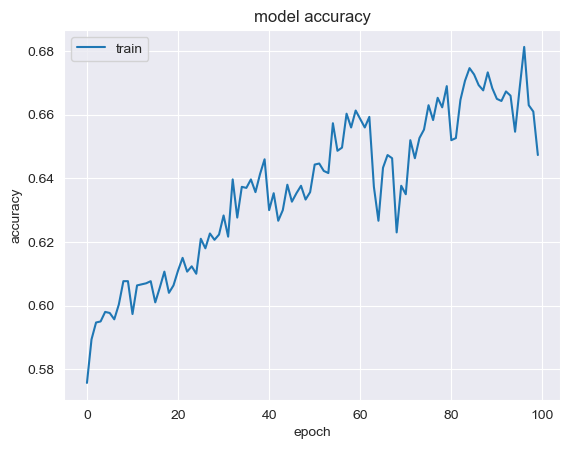

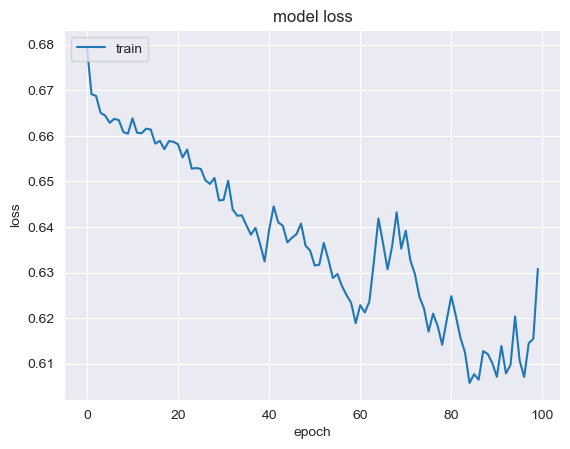

In [467]:
plot_model(ltsm_classifer)

In [468]:
evaluate_model(ltsm_model)

32/32 [==============================] - 2s 27ms/step - loss: 0.6041 - accuracy: 0.6790
Accuracy: 67.90
0.604 0.679


In [469]:
print("************ LSTM Evaluation ************")
print(f"Compiled with {CV_ltsm.best_params_}")
print(vitals_filename)
print(shape(X_sequences))
test_accuracy(ltsm_model)

************ LSTM Evaluation ************
Compiled with {'dropout': 0.3, 'recurrent_activation': 'hard_sigmoid', 'units': 48}
vitals_data_before_and_after_ABC.csv
11/11 [==============================] - 1s 23ms/step
   Accuracy  Balanced Accuracy    MCC  F1-Score
0     0.593              0.594  0.189     0.588


In [470]:
print(f"Unique subject ids {vitals_data_df['subject_id'].nunique()}")


Unique subject ids 1539
